## Set Up

In [1]:
import pandas as pd
import numpy as np
import datetime
from datetime import timedelta
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import json
import warnings
warnings.filterwarnings('ignore')

In [2]:
%load_ext version_information
%version_information pandas, numpy, matplotlib, seaborn, json

Software versions
Python 3.5.2 64bit [GCC 4.2.1 Compatible Apple LLVM 4.2 (clang-425.0.28)]
IPython 5.1.0
OS Darwin 16.1.0 x86_64 i386 64bit
pandas 0.18.1
numpy 1.11.1
matplotlib 1.5.3
seaborn 0.7.1
json 2.0.9
Thu Mar 09 22:02:25 2017 PST

In [3]:
# customized plot style
s = json.load( open("plot_style.json") )
matplotlib.rcParams.update(s)

# costomized color palette
pal = sns.xkcd_palette(['azure', 'dark blue'])

## Data Cleaning

In [4]:
apps = pd.read_csv('apps_v2.csv')
print(apps.shape)

(175182, 35)


175k+ apps were randomly sampled from Apple app store using iTunes API.   
*Note*: The total number of apps in Apple app store were 2 million as of 2016.

In [5]:
# columns
apps.columns.values

array(['advisories', 'artistId', 'artistName', 'averageUserRating',
       'averageUserRatingForCurrentVersion', 'bundleId',
       'contentAdvisoryRating', 'currency', 'currentVersionReleaseDate',
       'description', 'features', 'fileSizeBytes', 'formattedPrice',
       'genreIds', 'genres', 'isGameCenterEnabled',
       'isVppDeviceBasedLicensingEnabled', 'kind', 'languageCodesISO2A',
       'minimumOsVersion', 'price', 'primaryGenreId', 'primaryGenreName',
       'releaseDate', 'releaseNotes', 'sellerName', 'supportedDevices',
       'trackCensoredName', 'trackContentRating', 'trackId', 'trackName',
       'userRatingCount', 'userRatingCountForCurrentVersion', 'version',
       'wrapperType'], dtype=object)

### Missing Values

In [6]:
# missing values
m = pd.isnull(apps).sum()
m[m!=0]

advisories                            130795
averageUserRating                     111556
averageUserRatingForCurrentVersion    107704
description                                1
features                               58863
languageCodesISO2A                       620
releaseNotes                           48472
userRatingCount                       111557
userRatingCountForCurrentVersion      107706
dtype: int64

In [7]:
# what values does the 'feature' column take?
apps.features.unique()

array([nan, 'iosUniversal'], dtype=object)

For the missing values:  
- Majority of `'advisories'` are missing; drop the column.
- For missing ratings and rating counts (`'averageUserRating'`, `'averageUserRatingForCurrentVersion'`, `'userRatingCount'`, `'userRatingCountForCurrentVersion'`), fill value as '**Not yet rated**' (for ratings) and '**0**' (for rating counts) because they most likely just have not been rated yet. 
- For `'languageCodesISO2A'` and `'releaseNotes'` that are missing, leave them as missing.  
- For missing `'features'`, fill values as '**Non-iosUniversal**'.  

In [8]:
# fill the missing values
apps['averageUserRating'].fillna('Not yet rated', inplace = True)
apps['averageUserRatingForCurrentVersion'].fillna('Not yet rated', inplace = True)
apps['userRatingCount'].fillna('0', inplace = True)
apps['userRatingCountForCurrentVersion'].fillna('0', inplace = True)

### Duplicates

In [9]:
# check duplicates -- entire data frame
sum(apps.duplicated())

0

In [10]:
# are apps (ids/names) unique
sum(apps[['trackId', 'trackName']].duplicated())

1045

Although the data frame contains no duplicates, the ids/names of the apps are actually not unique. Why? Should have something to do with version. Below is a quick check using Facebook app as an example.

In [11]:
# a quick look at the Facebook app
apps.loc[apps['trackName'] == 'Facebook', ['trackId', 'trackName', 'averageUserRating', \
                                           'averageUserRatingForCurrentVersion',\
                                           'version']]

,trackId,trackName,averageUserRating,averageUserRatingForCurrentVersion,version
2445,284882215,Facebook,3.5,2.5,80.0
93472,284882215,Facebook,3.5,3,81.0


Indeed, an app can have several different versions available in the app store. That's why there are two different ratings: `'averageUserRating'` and `'averageUserRatingForCurrentVersion'`. 

### Data Types

There are timestamps in the data frame but are not in the correct type. So they need to be converted.

In [12]:
# Convert 'releaseDate' and 'currentVersionReleaseDate' to datetime
apps['releaseDate'] = apps['releaseDate'].apply(lambda x: \
                                                datetime.datetime.strptime(x, \
                                                                           '%Y-%m-%dT%H:%M:%SZ'))
apps['currentVersionReleaseDate'] = apps['currentVersionReleaseDate'].apply(lambda x: \
                                                                            datetime.datetime.strptime(x, \
                                                                                                       '%Y-%m-%dT%H:%M:%SZ'))

# Add a 'year' variable 
apps['releaseYr'] = apps['releaseDate'].apply(lambda x: x.year)
apps['currentVersionReleaseYr'] = apps['currentVersionReleaseDate'].apply(lambda x: x.year)

## Data Visualization

### When are the Apps Released? -Current Version Release Date

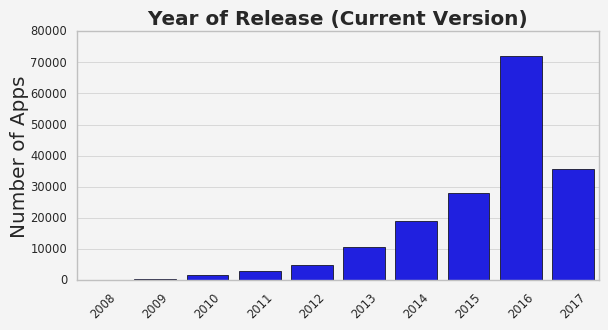

In [13]:
# When are the apps released?
p = sns.countplot(x = 'currentVersionReleaseYr', data = apps, color = 'blue', edgecolor = 'black')
p.set(xlabel = '', ylabel = 'Number of Apps')
p.set_title('Year of Release (Current Version)', fontweight = 'bold')
for item in p.get_xticklabels():
    item.set_rotation(45)
plt.show()

In [14]:
apps[apps['currentVersionReleaseYr'] >= 2015].shape[0]/apps.shape[0]

0.7743603794910436

Based on the 175k+ apps I randomly sampled, we can see that the release years of apps currently in the Apple app stores span across a decade, but over 75% of them were released in 2015 or later. We can expect the number of apps from 2017 to at least double from last year's number based on the data we have so far (until Feburary). With the exponentially growing number of apps, one question arises. Are we users actually being offered better apps? 

### App Ratings and How They Change over Time

Before we actually delve into app ratings, one thing to note is that there are a larger number of apps without ratings. We can compare the number of apps with ratings and without ratings and also check to see if apps without ratings are simply too new.

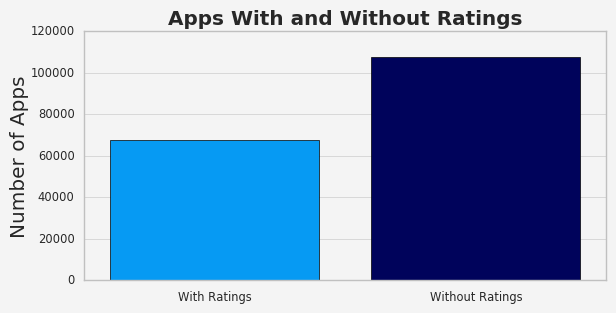

In [15]:
# Add new variable to differentiate apps with ratings and without ratings
apps['ratings'] = 'With Ratings'
apps.loc[apps['averageUserRatingForCurrentVersion'] == 'Not yet rated', \
         'ratings'] = 'Without Ratings'

p = sns.countplot(x = 'ratings', data = apps, palette = pal, saturation = 1, edgecolor = 'black')
p.set(xlabel = '', ylabel = 'Number of Apps')
p.set_title('Apps With and Without Ratings', fontweight = 'bold')
plt.show()

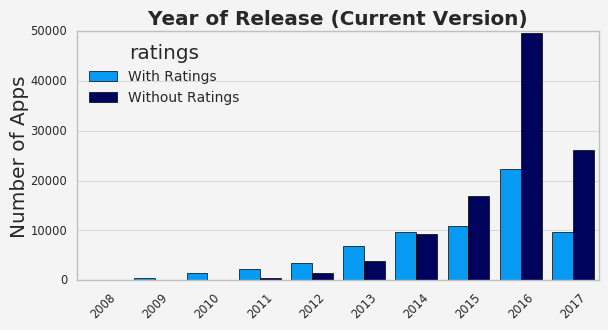

In [16]:
p = sns.countplot(x = 'currentVersionReleaseYr', data = apps, \
                  palette = pal, hue = 'ratings', saturation = 1, edgecolor = 'black')
p.set(xlabel = '', ylabel = 'Number of Apps')
p.set_title('Year of Release (Current Version)', fontweight = 'bold')
for item in p.get_xticklabels():
    item.set_rotation(45)
plt.show()

The year of 2014 seems to be the border. For apps released earlier than 2014, the majority of them are rated; but for apps released after 2014, more unrated than rated. In particular, over a half of the apps from 2016 do not have a rating. 

#### Apps with Ratings

For apps with ratings: 
- What does the ratings look like? 
- Are newer apps having higher or lower ratings?
- How does the count of ratings play a role?

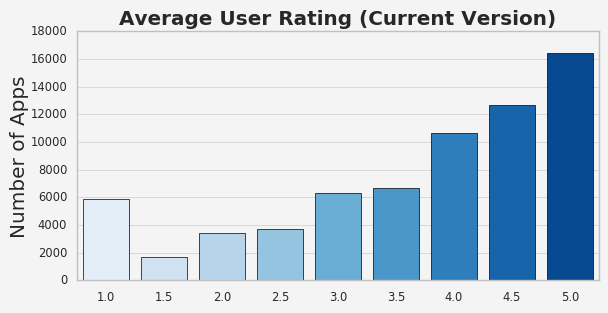

In [17]:
# subset a data frame of apps with ratings
rated = apps[apps['ratings'] == 'With Ratings']

p = sns.countplot(x = 'averageUserRatingForCurrentVersion', \
              data = rated, palette = 'Blues', saturation = 1.0, edgecolor = 'black')
p.set(xlabel = '', ylabel = 'Number of Apps')
p.set_title('Average User Rating (Current Version)', fontweight = 'bold')
plt.show()

This is interesting - the number of apps increases with the average user ratings for ratings from 1.5 to 5.0. But the number of apps with rating of 1.0 sticks out! Later, we can see if those rated 1.0 apps have something in common.

In [18]:
# Some statistics
print('Mean of Ratings: {}'.format(rated.averageUserRatingForCurrentVersion.mean()))
print('Median of Ratings: {}'.format(rated.averageUserRatingForCurrentVersion.median()))
print('Standard Deviation of Ratings: {}'.format(rated.averageUserRatingForCurrentVersion.std()))

Mean of Ratings: 3.686142150034085
Median of Ratings: 4.0
Standard Deviation of Ratings: 1.2573226776487243


There are 9 distinct numeric ratings. To simplify, they can be coded into two categories: 'High', and 'Low'. We use the median rating 4.0 as the breaking point to divided the apps.

In [19]:
rated['ratingCategory'] = 'High'
rated.loc[rated['averageUserRatingForCurrentVersion'] < 4.0, 'ratingCategory'] = 'Low'

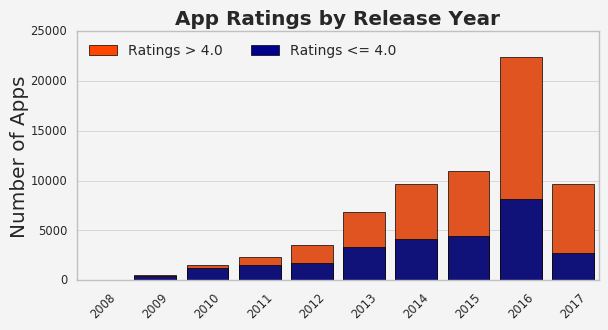

In [20]:
# Are newer apps having higher ratings or lower ratings?
p = sns.countplot(x = 'currentVersionReleaseYr', data = rated,  color = "orangered", edgecolor = 'black')
bottom_plot = sns.countplot(x = 'currentVersionReleaseYr', \
                            data = rated[rated['ratingCategory'] == 'Low'], color = "darkblue", edgecolor = 'black')
p.set(xlabel = '', ylabel = 'Number of Apps')
p.set_title('App Ratings by Release Year', fontweight = 'bold')
topbar = plt.Rectangle((0,0),1,1, fc = "orangered", edgecolor = 'black')
bottombar = plt.Rectangle((0,0),1,1, fc = 'darkblue',  edgecolor = 'black')
l = plt.legend([topbar, bottombar], ['Ratings > 4.0', 'Ratings <= 4.0'], loc = 0, \
               ncol = 2, prop={'size':10})
l.draw_frame(False)
for item in p.get_xticklabels():
    item.set_rotation(45)
plt.show()

In [21]:
# Another way of looking at this problem is to plot the distribution of average user ratings by year
rated['averageUserRatingForCurrentVersion'] = rated['averageUserRatingForCurrentVersion'].astype('float')
rated_byyear = rated.groupby('currentVersionReleaseYr').agg({'averageUserRatingForCurrentVersion': 'median'}).reset_index()
rated_byyear.columns = ['currentVersionReleaseYr', 'medianRating']

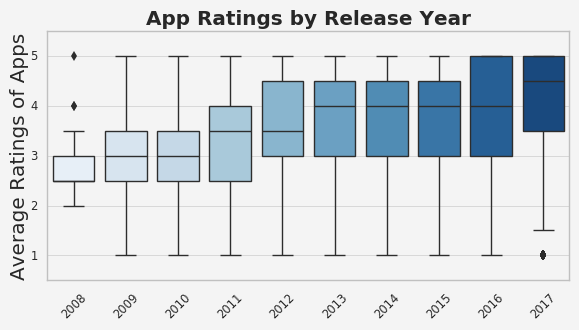

In [22]:
p = sns.boxplot(x = 'currentVersionReleaseYr', y = 'averageUserRatingForCurrentVersion', \
                   data = rated, palette = 'Blues', linewidth = 1.0)
plt.ylim((0.5, 5.5))
p.set(xlabel = '', ylabel = 'Average Ratings of Apps')
p.set_title('App Ratings by Release Year', fontweight = 'bold')
for item in p.get_xticklabels():
    item.set_rotation(45)
plt.show()

It looks like at least based on the average user ratings, we are being offered not only more apps but also better apps as year goes by! But with so many apps having ratings 4.0 or higher, apps with ratings below 4.0 are probably having a hard time.

#### Ratings vs Rating Counts

Looking at numeric ratings only without taking into account the rating count is probably not an good idea. 

In [23]:
rating_count = rated[rated['userRatingCountForCurrentVersion'] != '0'] # remove row without counts
rating_count['userRatingCountForCurrentVersion'] = rating_count['userRatingCountForCurrentVersion'].astype('int')
rating_count = rating_count.sort_values('userRatingCountForCurrentVersion', ascending = False)

# top 10 most reviewed apps
rating_count[['trackId', 'trackName', 'version', 'averageUserRatingForCurrentVersion', \
              'userRatingCountForCurrentVersion']].head(10)

,trackId,trackName,version,averageUserRatingForCurrentVersion,userRatingCountForCurrentVersion
42725,322410766,Waterslide Extreme,1.1.0,3.0,209827
169808,387428400,Infinity Blade,1.4.1,5.0,177027
63828,324316024,Mirror Mirror (FREE),1.0,1.5,140208
100663,430537691,Stupidness 2,1.1,4.0,118331
152520,1045901853,Geometry Dash Meltdown,1.0,4.5,111634
39091,356053562,LIE DETECTOR... FREE!,1,2.5,100632
55529,597855590,Real Basketball,1.9,4.5,94287
26699,808176012,Flappy Wings - FREE,2.5,4.5,83751
63191,345294723,How to KISS,1,3.5,71987
164847,354870202,Adult Sex Trick,1.4,1.5,71223


Mostly reviewed seems not necessarily mean highest rating from the top 10 list. So what exactly is the relationship between ratings and number of ratings?

In [24]:
# statistics of rating counts
print('Maximum Rating Counts: {}'.format(rating_count.userRatingCountForCurrentVersion.max()))
print('Minimum Rating Counts: {}'.format(rating_count.userRatingCountForCurrentVersion.min()))
print('Mean of Rating Counts: {}'.format(rating_count.userRatingCountForCurrentVersion.mean()))
print('Median of Rating Counts: {}'.format(rating_count.userRatingCountForCurrentVersion.median()))
print('Standard Deviation of Rating Counts: {}'.format(rating_count.userRatingCountForCurrentVersion.std()))
print('75% Percentile of Rating Counts: {}'.format(np.percentile(rating_count.userRatingCountForCurrentVersion, 75)))
print('25% Percentile of Rating Counts: {}'.format(np.percentile(rating_count.userRatingCountForCurrentVersion, 25)))

Maximum Rating Counts: 209827
Minimum Rating Counts: 1
Mean of Rating Counts: 166.1577098648328
Median of Rating Counts: 6.0
Standard Deviation of Rating Counts: 1958.4857179925016
75% Percentile of Rating Counts: 29.0
25% Percentile of Rating Counts: 2.0


The distribution of rating counts is significantly skewed. With the 25% and 75% percentile rating counts, the apps can be divided into three categories, one with rating count above 75% percentile, one below 25% percentile, and one within the inter-quartile range.

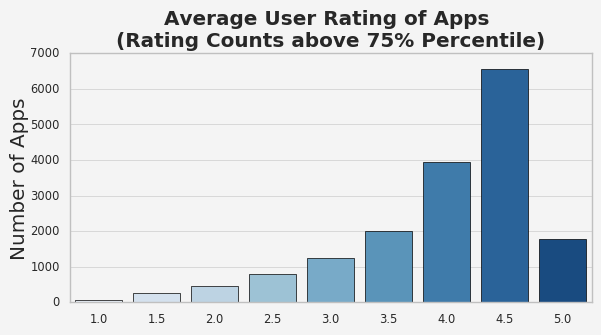

In [27]:
count_75 = rating_count[rating_count['userRatingCountForCurrentVersion'] >= 29]
p = sns.countplot(x = 'averageUserRatingForCurrentVersion', data = count_75, \
                  palette = 'Blues', edgecolor = 'black')
p.set(xlabel = '', ylabel = 'Number of Apps')
p.set_title('Average User Rating of Apps \n(Rating Counts above 75% Percentile)', \
            fontweight = 'bold')
plt.show()

In [28]:
print('For apps with 75% percentile rating counts:')
print('Mean of Ratings: {}'.format(count_75.averageUserRatingForCurrentVersion.mean()))
print('Median of Ratings: {}'.format(count_75.averageUserRatingForCurrentVersion.median()))
print('Standard Deviation of Ratings: {}'.format(count_75.averageUserRatingForCurrentVersion.std()))

For apps with 75% percentile rating counts:
Mean of Ratings: 3.9947904472020603
Median of Ratings: 4.0
Standard Deviation of Ratings: 0.7947110610391772


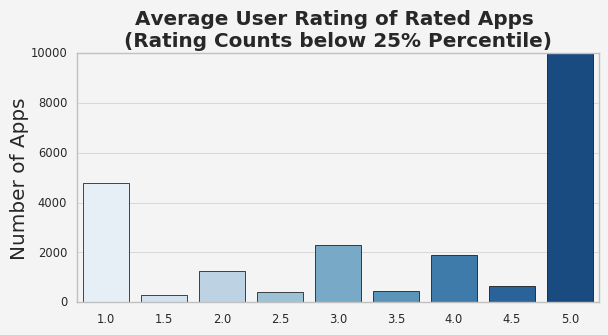

In [29]:
count_25 = rating_count[rating_count['userRatingCountForCurrentVersion'] <= 2]
p = sns.countplot(x = 'averageUserRatingForCurrentVersion', data = count_25, \
                  palette = 'Blues', edgecolor = 'black')
p.set(xlabel = '', ylabel = 'Number of Apps')
p.set_title('Average User Rating of Rated Apps \n(Rating Counts below 25% Percentile)', \
            fontweight = 'bold')
plt.show()

In [30]:
print('For apps with 25% percentile rating counts:')
print('Mean of Ratings: {}'.format(count_25.averageUserRatingForCurrentVersion.mean()))
print('Median of Ratings: {}'.format(count_25.averageUserRatingForCurrentVersion.median()))
print('Standard Deviation of Ratings: {}'.format(count_25.averageUserRatingForCurrentVersion.std()))

For apps with 25% percentile rating counts:
Mean of Ratings: 3.5295970629560802
Median of Ratings: 4.0
Standard Deviation of Ratings: 1.6268567019185773


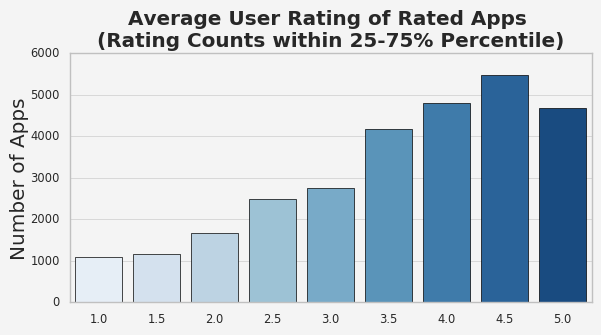

In [31]:
IQR = rating_count.loc[(rating_count.userRatingCountForCurrentVersion > 2) & \
                       (rating_count.userRatingCountForCurrentVersion < 29), ]
p = sns.countplot(x = 'averageUserRatingForCurrentVersion', data = IQR, \
                  palette = 'Blues', edgecolor = 'black')
p.set(xlabel = '', ylabel = 'Number of Apps')
p.set_title('Average User Rating of Rated Apps \n(Rating Counts within 25-75% Percentile)', \
            fontweight = 'bold')
plt.show()

In [32]:
print('For apps within 25-75% percentile rating counts:')
print('Mean of Ratings: {}'.format(IQR.averageUserRatingForCurrentVersion.mean()))
print('Median of Ratings: {}'.format(IQR.averageUserRatingForCurrentVersion.median()))
print('Standard Deviation of Ratings: {}'.format(IQR.averageUserRatingForCurrentVersion.std()))

For apps within 25-75% percentile rating counts:
Mean of Ratings: 3.6218887908208295
Median of Ratings: 4.0
Standard Deviation of Ratings: 1.1146963616766101


The above comparison shows some interesting difference. But they are actually not surprising. 
- For apps having rating counts within the inter-quartile range, the number of apps associates positively with the ratings, with the number of 5.0 apps is slightly smaller.  
- For apps with the largest number of ratings (count >= 29), the apps are more likely to have higher ratings but the number of apps with 5.0 rating is actually smaller. No doubt these are popular apps. But with more people rating an app, it is more difficult for it to get a perfect score.
- It is almost the opposite for apps with only a couple of ratings (count = 1 or 2). The ratings are either very high or very low. We would guess that the apps with only one or two 5.0 ratings are likely to be more recent. We can see if it is true.

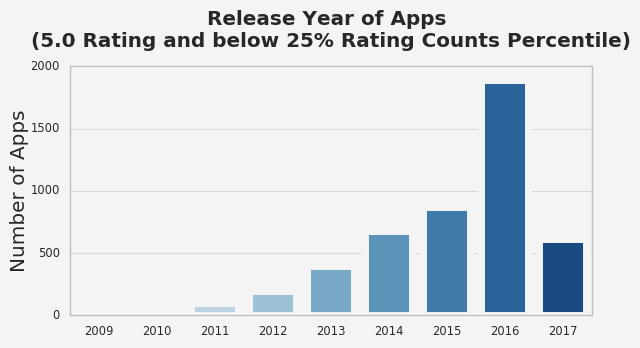

In [33]:
p = sns.countplot(x = 'currentVersionReleaseYr', \
                  data = count_25[count_25['averageUserRatingForCurrentVersion'] == 1.0], \
                  palette = 'Blues', linewidth = 5.0)
p.set(xlabel = '', ylabel = 'Number of Apps')
p.set_title('Release Year of Apps \n(5.0 Rating and below 25% Rating Counts Percentile)', \
            fontweight = 'bold', y = 1.05)
plt.show()

Well, it looks like those apps with only one or two 5.0 ratings are not more likely to be newer than apps with lower ratings because we are seeing a distribution very similar to the population. 

The distribution of ratings for apps released in different years and have different rating counts can be viewed by box plot. 

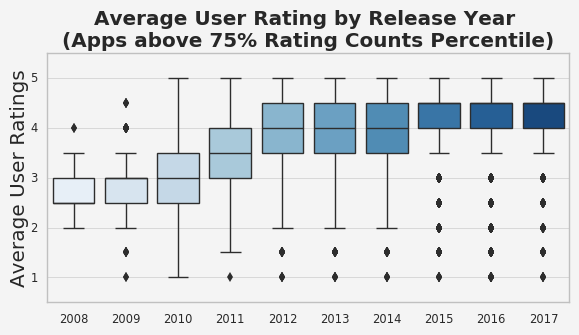

In [34]:
p = sns.boxplot(x = 'currentVersionReleaseYr', y = 'averageUserRatingForCurrentVersion', \
                   data = count_75, palette = 'Blues', linewidth = 1.0)
p.set(xlabel = '', ylabel = 'Average User Ratings')
p.set_title('Average User Rating by Release Year \n(Apps above 75% Rating Counts Percentile)', \
            fontweight = 'bold')
plt.ylim((0.5, 5.5))
plt.show()

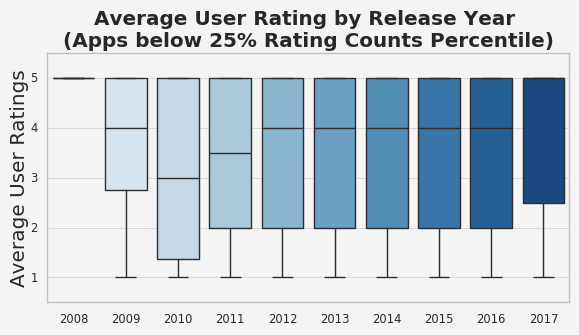

In [35]:
p = sns.boxplot(x = 'currentVersionReleaseYr', y = 'averageUserRatingForCurrentVersion', \
                   data = count_25, palette = 'Blues', linewidth = 1.0)
p.set(xlabel = '', ylabel = 'Average User Ratings')
p.set_title('Average User Rating by Release Year \n(Apps below 25% Rating Counts Percentile)', \
            fontweight = 'bold')
plt.ylim((0.5, 5.5))
plt.show()

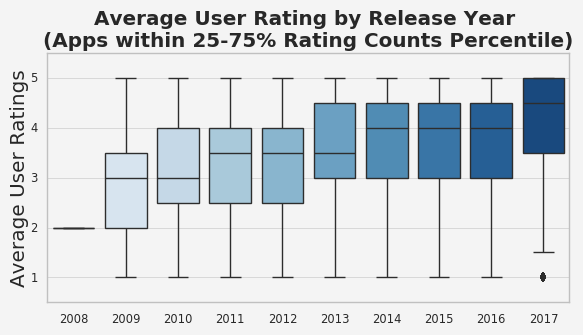

In [36]:
p = sns.boxplot(x = 'currentVersionReleaseYr', y = 'averageUserRatingForCurrentVersion', \
                   data = IQR, palette = 'Blues', linewidth = 1.0)
p.set(xlabel = '', ylabel = 'Average User Ratings')
p.set_title('Average User Rating by Release Year \n(Apps within 25-75% Rating Counts Percentile)', \
            fontweight = 'bold')
plt.ylim((0.5, 5.5))
plt.show()

There are a lot of information in the above three box plots. One obvious observation is the width of the boxes! Clearly, more rating counts means narrower rating distribution (although they can still have maximum rating of 5.0 and minimum rating of 1.0).

## The End